In [1]:
%pylab
%matplotlib inline
import SimMLA.fftpack as simfft
import SimMLA.grids   as grids

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


# Simulation of partially coherent beams
The rotating diffuser in the illuminator setup has the effect of randomizing the phase of the incident laser beam. This randomization results in a decrease in the spatial coherence of the beam, which smears out the array resulting from the coherent beam illumination.

To simulate the effect of partial spatial coherence, I am employing a simulation strategy detailed in [Xiao and Voelz, Optics Express 14, 6986-6992 (2006)](https://www.osapublishing.org/oe/fulltext.cfm?uri=oe-14-16-6986&id=96179). The strategy employed in this paper is to firstgenerate a random phase screen that satisfies the Gaussian-Schell model. The input field is multipled by this phase screen and then propagated through the illuminator to the sample. Another phase screen is generated and the process is repeated a large number of times. The average irradiance on the sample becomes the average over these realizations.

In [2]:
# Create a grid to sample the input field and build the coherence function on
numLenslets  = 21    # Must be odd; corresponds to the number of lenslets in one dimension
lensletSize  = 500   # microns
focalLength  = 13700 # microns

wavelength   = 0.642 # microns

subgridSize  = 10001                     # Number of grid (or lattice) sites for a single lenslet
physicalSize = numLenslets * lensletSize # The full extent of the MLA

# dim = 1 makes the grid 1D
grid = grids.GridArray(numLenslets, subgridSize, physicalSize, wavelength, focalLength, dim = 1)

To generate a Gaussian Schell model beam, the variable `GS_Criterion` must be much greater than one. The primary effect of ensuring this is to eliminate the independence of the two parameters \\( \sigma_r \\) and \\( \sigma_f \\) and instead make the partial coherence of the beam dependent only upon the value of `GS_Criterion`.

Next, we generate an array of random numbers with variance \\( \sigma_r \\) and a size equal to the input field. This array is convolved with a Gaussian using FFT's.

In [117]:
# Define the amplitude variation and correlation length of the phase screen
sigma_r = 1000 * np.sqrt(4 * np.pi) # amplitude variation, microns
sigma_f = 100                       # correlation length, microns

GS_Criterion = sigma_r**2 / 4 / np.pi / sigma_f**2
print('{0:.4f}'.format(GS_Criterion))
print('GSM coherence length: {0:.4f}'.format(8 * np.pi * sigma_f**4 / sigma_r**2))

100.0000
GSM coherence length: 200.0000


The variance of a uniform distribution is \\( \frac{1}{12} \left( b - a \right)^2 \\). In Python, `np.random.rand` outputs numbers between \\(a = 0\\) and \\(b = 1\\). To get a uniform random variable with a variance equal to \\( \sigma_r^2 \\), we should multiply the output of `np.random.rand` with \\( \sigma_r \sqrt{12} \\).

In [118]:
randNum = sigma_r * np.sqrt(12) * np.random.rand(grid.gridSize)

print('Theoretical variance: {0:.4f}'.format(sigma_r**2))
print('Simulated variance: {0:.4f}'.format(np.var(randNum)))

Theoretical variance: 12566370.6144
Simulated variance: 12582816.1063


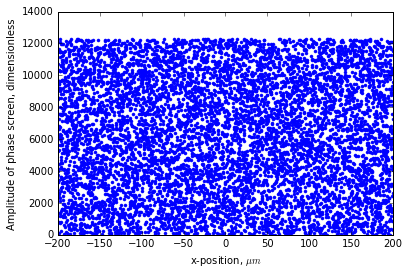

In [119]:
dx            = grid.px[1] - grid.px[0]

# Show a subsection of the phase screen
plt.plot(grid.px, randNum, '.')
plt.xlim((-200, 200))
plt.xlabel(r'x-position, $\mu m$')
plt.ylabel('Amplitude of phase screen, dimensionless')
plt.show()

Now we construct a Gaussian function and convolve it with this noise.

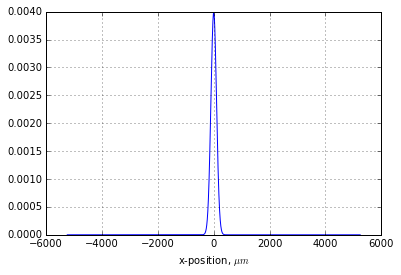

In [121]:
f = 1 / np.sqrt(2 * np.pi) / sigma_f * np.exp(-(grid.px**2) / 2 / sigma_f**2)

plt.plot(grid.px, f)
plt.xlabel(r'x-position, $\mu m$')
plt.grid(True)
plt.show()

In [122]:
F    = dx * np.fft.fft(np.fft.fftshift(f))
Rand = dx * np.fft.fft(np.fft.fftshift(randNumNormed))

Conv = F * Rand
conv = (1/dx) * np.fft.ifftshift(np.fft.ifft(Conv))

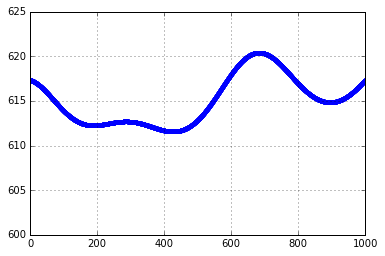

In [123]:
# Is the noise correlated?
plt.plot(grid.px, np.abs(conv), '.')
plt.xlim((0, 1000))
plt.grid(True)
plt.show()

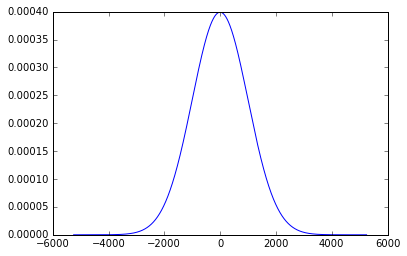

In [126]:
# Generate a Gaussian input beam
beamStd = 1000 # microns
uIn   = lambda x: (1 + 0j) / np.sqrt(2 * np.pi) / beamStd * exp(-x**2 / 2 / beamStd**2)
uIn   = np.vectorize(uIn)

# Field passed through the random phase screen
uRand = uIn(grid.px) * np.exp(1j * conv)

plt.plot(grid.px, np.abs(uRand))
plt.show()

In [127]:
F = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(uRand))) * dx / grid.wavelength / grid.focalLength

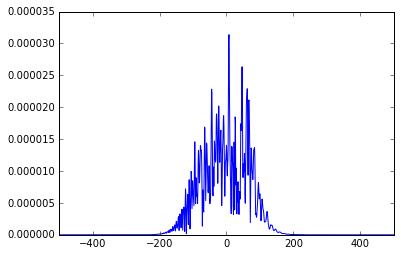

In [129]:
plt.plot(grid.pX, np.abs(F))
plt.xlim((-500,500))
plt.show()